In [1]:
import scipy.io
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from fancy_plots import fancy_plots_3
from fancy_plots import plot_states_angles_estimation, plot_states_velocity_lineal_estimation, plot_states_velocity_angular_estimation, plot_control_states_estimation
from fancy_plots import fancy_plots_2
from fancy_plots import fancy_plots_1, plot_error_estimation, plot_states_position_estimation

In [2]:
def get_odometry(data, angle, vx, vy, vz, wx, wy, wz, vel_control, steer_control, samples):
    # Get size of the data
    i, j = data.shape
    # Init empty values
    x = np.zeros((1, j), dtype = np.double)
    y = np.zeros((1, j), dtype = np.double)
    z = np.zeros((1, j), dtype = np.double)
    quatenions = np.zeros((4, j), dtype = np.double)
    orientation_aux = np.zeros((3, j), dtype = np.double)
    
    for k in range(0, j):
        
        # Get Position
        x[:, k] = data[0, k]
        y[:, k] = data[1, k]
        z[:, k] = 0
        
        # Get quaternion
        quatenions[:, k] = [data[2, k], data[3, k], data[4, k], data[5, k]]
        
        # Get Euler Angles
        aux =  quatenions[:, k]
        r = R.from_quat(aux)
        orientation_aux[:, k] = r.as_euler('xyz', degrees = False)
        
    # get complete data of the system
    h = np.array([x[0,:], y[0,:], z[0,:],
                quatenions[0, :], quatenions[1, :], quatenions[2, :], quatenions[3, :],
                orientation_aux[0, :], orientation_aux[1, :], orientation_aux[2, :],
                angle[0, :]], dtype =np.double) 
    
    # Get Velocities of the system
    hp = np.array([vx[0, :], vy[0, :], vz[0, :], wx[0, :], wy[0, :], wz[0, :]], dtype = np.double)
    T = np.array([vel_control[0,:], steer_control[0, :]], dtype = np.double)
    return h[:, 0:samples+1], hp[:, 0:samples+1], T[:, 0:samples]


In [3]:
def get_simple_data(h, hp, T):
    ## Position
    x = h[0, :]
    y = h[1, :]
    ## Linear velocities
    vx = hp[0, :]
    vy = hp[1, :]
    vz = hp[2, :]
    
    ## Get angular velocities
    p = hp[3, :]
    q = hp[4, :]
    r = hp[5, :]
    
    ## Angular velocities vector
    omega = hp[3:6, :]
    
    ## Orientacion
    quaternion = h[3:7, :]
    
    ##euler
    euler = h[7:10, :]
    
    ## Steer angle = 
    alpha = h[10, :]
    
    ## General states data
    #X = np.array([euler[2,:], omega[2, :], alpha, vx, vy], dtype = np.double)
    X = np.array([euler[0, :], euler[1, :], euler[2, :], omega[0, :], omega[1, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    ## Control Action
    U_ref = T[:, :]
    
    ## Get the dimension of the Data
    i, j = X.shape
    
    X1 = X[:, 0:j-1]
    X2 = X[:, 1:j]
    return X1, X2, U_ref

In [4]:
def liftFun(x):
    x_lift = []
    for k in x: x_lift.append(k)
    x_lift.append(np.sin(x[0, :])*np.tan(x[1, :])*x[4, :])
    x_lift.append(np.cos(x[0, :])*np.tan(x[1, :])*x[5, :])
    x_lift.append(np.cos(x[0, :])*x[4, :])
    x_lift.append(np.sin(x[0, :])*x[5, :])
    x_lift.append(np.sin(x[0, :])/np.cos(x[1, :])*x[4, :])
    x_lift.append(np.cos(x[0, :])/np.cos(x[1, :])*x[5, :])
    x_lift.append(x[3, :]*x[4, :])
    x_lift.append(x[3, :]*x[5, :])
    x_lift.append(x[4, :]*x[5, :])

    x_lift.append(np.tan(x[6, :]))

    x_lift.append(np.tan(x[6, :])*x[7, :])

    x_lift.append(np.cos(x[6, :])*x[7, :])
    x_lift.append(np.sin(x[6, :])*x[7, :])
    x_lift.append(np.cos(x[6, :])*x[8, :])
    x_lift.append(np.sin(x[6, :])*x[8, :])
    
    x_lift.append((x[5, :]*x[7, :]))
    x_lift.append((x[5, :]*x[8, :]))

    x_lift.append(np.cos(x[2, :])*x[7, :])
    x_lift.append(np.sin(x[2, :])*x[8, :])

    x_lift.append(np.sin(x[2, :])*x[7, :])
    x_lift.append(np.cos(x[2, :])*x[8, :])

    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift


In [5]:
def liftFun_vector(x):
    x_lift = []
    for k in x: x_lift.append(k)
    x_lift.append(np.sin(x[0])*np.tan(x[1])*x[4])
    x_lift.append(np.cos(x[0])*np.tan(x[1])*x[5])
    x_lift.append(np.cos(x[0])*x[4])
    x_lift.append(np.sin(x[0])*x[5])
    x_lift.append(np.sin(x[0])/np.cos(x[1])*x[4])
    x_lift.append(np.cos(x[0])/np.cos(x[1])*x[5])
    x_lift.append(x[3]*x[4])
    x_lift.append(x[3]*x[5])
    x_lift.append(x[4]*x[5])

    x_lift.append(np.tan(x[6]))

    x_lift.append(np.tan(x[6])*x[7])

    x_lift.append(np.cos(x[6])*x[7])
    x_lift.append(np.sin(x[6])*x[7])
    x_lift.append(np.cos(x[6])*x[8])
    x_lift.append(np.sin(x[6])*x[8])

    x_lift.append((x[5]*x[7]))
    x_lift.append((x[5]*x[8]))

    x_lift.append(np.cos(x[2])*x[7])
    x_lift.append(np.sin(x[2])*x[8])

    x_lift.append(np.sin(x[2])*x[7])
    x_lift.append(np.cos(x[2])*x[8])

    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift

In [6]:
def create_matrix(A, data):
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            A[i, j] = data[i, j]
    return A

In [7]:
def cost_function_koopman(X_1, X_k, U, alpha, beta, n, m, n_normal):
    # Create Matrices of the system
    A = ca.MX.sym('A', n, n)
    B = ca.MX.sym('B', n, m)
    C_ones = ca.MX.eye(n_normal)
    C_zeros = ca.MX.zeros(n_normal, n-n_normal)
    C_a = ca.horzcat(C_ones, C_zeros)
    
    ## Create data in Casadi variables
    i_states, j_states = X_1.shape
    i_control, j_control = U.shape
    
    X_1_ca = ca.MX.zeros(i_states, j_states)
    X_1_ca = create_matrix(X_1_ca, X_1)
    
    X_k_ca = ca.MX.zeros(i_states, j_states)
    X_k_ca = create_matrix(X_k_ca, X_k)
    
    U_ca = ca.MX.zeros(i_control, j_control)
    U_ca = create_matrix(U_ca, U)

    ## Initial cost
    obj = 0

    args = {}
    
    for k in range(0, U_ca.shape[1]):
        x_1 = C_a@X_1_ca[:, k]
        x_k = C_a@X_k_ca[:, k]
        
        Gamma_k = X_k_ca[:, k]
        Gamma_1 = X_1_ca[:, k]
        
        error_koop = Gamma_k - A@Gamma_1 - B@U_ca[:, k]
        error_prediction = x_k - C_a@(A@Gamma_1 + B@U_ca[:, k])
        obj = obj + beta*ca.norm_fro(error_koop) + ca.norm_fro(error_prediction) 
    
    obj = obj + alpha*ca.norm_fro(A) + alpha*ca.norm_fro(B)

    OPT_variables = ca.vertcat(A.reshape((-1, 1)), B.reshape((-1, 1)))
    # Initial Values Problem 
    A_0 = ca.DM.eye(n)*0.1
    B_0 = ca.DM.ones(n, m)*0.1

    # Definition optimal control problem
    nlp_prob = {'f': obj,'x': OPT_variables}
    opts = {'ipopt': {'max_iter': 100, 'print_level': 1, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6},'print_time': 1}
    
    # Initial condition s definition
    args['x0'] = ca.vertcat(A_0.reshape((-1, 1)), B_0.reshape((-1, 1)))
    
    # Defintion of the optimal control problem
    solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
    sol = solver(x0=args['x0'])

    # Solution optimal control problem
    Solution = sol['x']

    Full_matrix = ca.reshape(Solution, n, n + m)
    Full_matrix_np = Full_matrix.full()

    # Get matrices
    A_final = Full_matrix_np[0:n, 0:n]
    B_final = Full_matrix_np[0:n, n:n+m]
    return A_final, B_final


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 171.27ms (  2.41ms) 170.61ms (  2.40ms)        71
  nlp_grad_f  | 100.72ms (  5.92ms) 100.37ms (  5.90ms)        17
  nlp_hess_l  |  64.85 s (  4.32 s)  64.59 s (  4.31 s)        15
       total  |  67.16 s ( 67.16 s)  66.90 s ( 66.90 s)         1


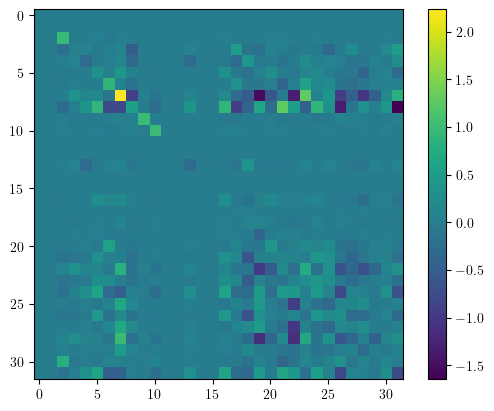

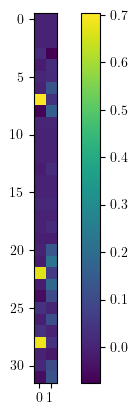

Error estimation norm
6.821215657269122
Print Eigvalues A
[ 3.93127019e-29+0.j          3.93127019e-29+0.j
  3.93126899e-29+0.j          3.93126899e-29+0.j
  3.93126899e-29+0.j          3.93126899e-29+0.j
  1.46076129e+00+0.j          1.00259844e+00+0.j
  9.98417827e-01+0.j          9.73412469e-01+0.j
  8.93354830e-01+0.j          8.60583623e-01+0.j
  6.99473875e-01+0.08929318j  6.99473875e-01-0.08929318j
 -5.79783295e-01+0.j          4.74866359e-01+0.j
 -3.61546722e-01+0.04176681j -3.61546722e-01-0.04176681j
  2.11473057e-01+0.08093428j  2.11473057e-01-0.08093428j
  4.01178129e-02+0.18920933j  4.01178129e-02-0.18920933j
 -6.88990631e-02+0.12379007j -6.88990631e-02-0.12379007j
 -4.12685770e-02+0.08388954j -4.12685770e-02-0.08388954j
 -6.95716533e-02+0.01702529j -6.95716533e-02-0.01702529j
  4.91695291e-02+0.j          4.00840887e-03+0.j
  6.82128572e-15+0.j         -2.24243865e-15+0.j        ]


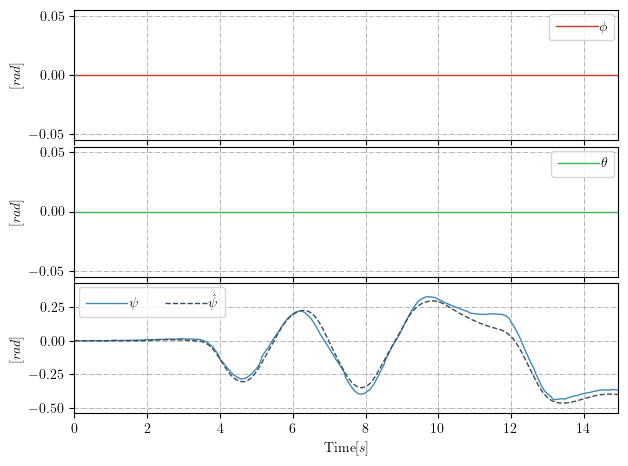

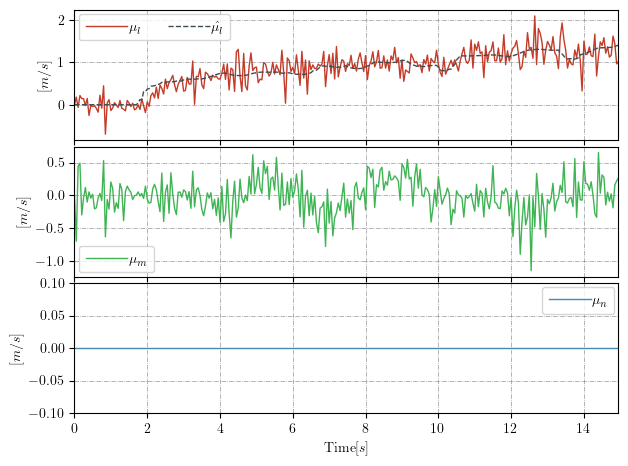

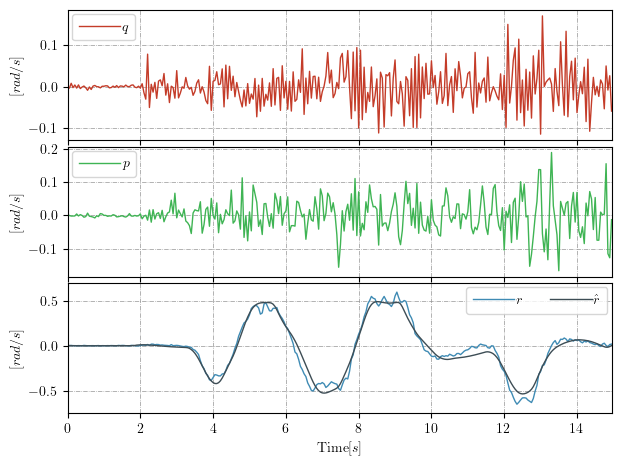

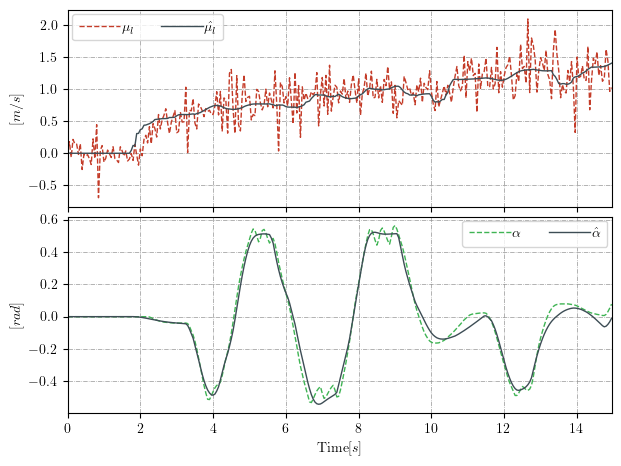

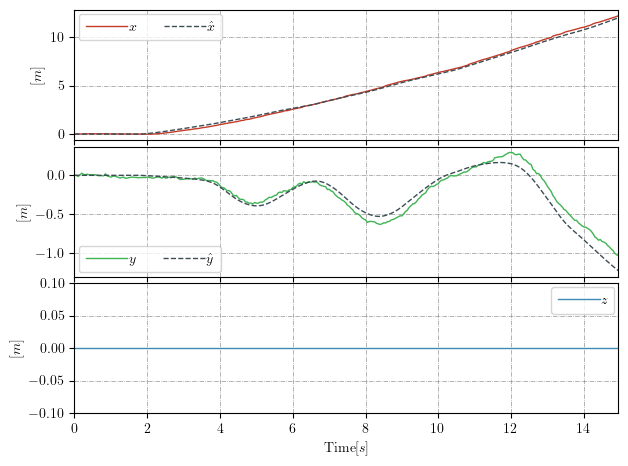

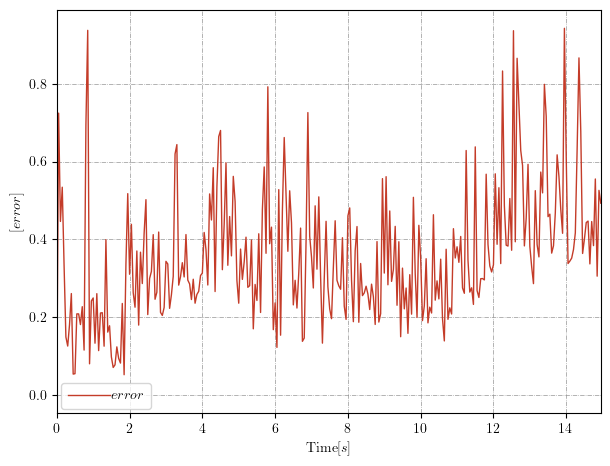

In [8]:
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h, hp, T = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 300)
## Compute sample time of the system
ts = 0.05
t = np.zeros((T.shape[1]), dtype = np.double)
for k in range(0, T.shape[1]-1):
    t[k+1] = t[k] + ts


## Get Data DMD
X1_n, X2_n, U_n = get_simple_data(h, hp, T)
n_normal = X1_n.shape[0]

# Koopman Space
X1 = liftFun(X1_n)
X2 = liftFun(X2_n)
U = U_n
n = X1.shape[0]
m = U.shape[0]

alpha = 0.2
beta = 0.5

# Optimization
A_a, B_a = cost_function_koopman(X1, X2, U, alpha, beta, n, m, n_normal)
C_ones = np.eye(n_normal, dtype = np.double)
C_zeros = np.zeros((n_normal, n - n_normal), dtype=np.double)
C_a = np.hstack((C_ones, C_zeros))

## Plot matrix A
plt.imshow(A_a)
plt.colorbar()
plt.show()
#
# Plot matrix B
plt.imshow(B_a)
plt.colorbar()
plt.show()
#
# New variables in order to verify the identification
x_estimate = np.zeros((n_normal, X1.shape[1]+1), dtype=np.double)
output_estimate = np.zeros((n_normal, U.shape[1]), dtype=np.double)
output_real = np.zeros((n_normal, U.shape[1]), dtype=np.double)
error_vector = np.zeros((n_normal, U.shape[1]), dtype=np.double)
norm_error = np.zeros((1, U.shape[1]), dtype = np.double)

# Initial value
x_estimate[:, 0] = C_a@X1[:, 0]

for k in range(0, U.shape[1]):
    output_estimate[:, k] = x_estimate[:, k]
    output_real[:, k] = C_a@X1[:, k]

    error_vector[:, k] = output_real[:, k] - output_estimate[:, k]
    norm_error[:, k] = np.linalg.norm(error_vector[:, k])

    aux_states = liftFun_vector(x_estimate[:, k])
    x_estimate[:, k+1] = C_a@(A_a@aux_states + B_a@U[:, k])

print("Error estimation norm")
print(np.linalg.norm(norm_error))
eig_A, eigv_A = np.linalg.eig(A_a)
print("Print Eigvalues A")
print(eig_A)

fig13, ax13, ax23, ax33 = fancy_plots_3()
plot_states_angles_estimation(fig13, ax13, ax23, ax33, h[7:10, :], output_estimate[:, :], t, "Euler Angles Of the system")
plt.show()

fig15, ax15, ax25, ax35 = fancy_plots_3()
plot_states_velocity_lineal_estimation(fig15, ax15, ax25, ax35, hp[0:3, :], output_estimate[:, :], t, "Lineal Velocity of the system")
plt.show()

fig16, ax16, ax26, ax36 = fancy_plots_3()
plot_states_velocity_angular_estimation(fig16, ax16, ax26, ax36, hp[3:6, :], output_estimate[:, :], t, "Angular Velocity of the system")
plt.show()

fig17, ax17, ax27 = fancy_plots_2()
plot_control_states_estimation(fig17, ax17, ax27, h[:, :], hp[:, :], output_estimate[:, :], t, "Control and Real Values of the system")
plt.show()

fig14, ax14, ax24, ax34 = fancy_plots_3()
plot_states_position_estimation(fig14, ax14, ax24, ax34, h[0:3, :], output_estimate[:, :], t, "Position of the system")
plt.show()

fig18, ax18 = fancy_plots_1()
plot_error_estimation(fig18, ax18, norm_error, t, 'Error Norm of the Estimation')
plt.show()
